# fMRI Data Loading and Normalization in Python 
**V.0.2 - Beta, [Contributions](#contributions)**   

### Goal of this script
 1. load the fMRI data into python
     - 2 localizer runs
 2. create an average brain mask from multiple runs
     - ses00_brain (2 localizer runs)
 3. trim TRs from the beginning AND end of each run (and apply this trimming to the confounds as well). Number of volumes trimmed defined by n_trunc_beginning and n_trunc_end. 
     - save volume as _trimXandXTRs.nii.gz
 4. apply a high-pass filter and z-score the data
     - save volume as _trimXandXTRs_normalized.nii.gz
 5. concatonate runs to make one time series
     - concatenated volumes saved as run-ALL
 6. plot a timeseries for a voxel

## Define subject

In [1]:
sub = 'sub-005'
ses = 'ses-01'
task='localizer'
n_trunc_beginning=5 #Number of volumes to trim from beginning of run
n_trunc_end=10 #Number of volumes to trim from end of run

## Import necessary packages

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
from nilearn.image.image import mean_img
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
#import seaborn as sns 
import scipy.io
import importlib

%matplotlib inline 
%autosave 5
#sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

Autosaving every 5 seconds


## Load settings

In [3]:
# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/analysis/mainanalysis')
import adderzip_utils
from adderzip_utils import load_adderzip_epi_data, load_data

importlib.reload(adderzip_utils)

# load some constants
from adderzip_utils import adderzip_dir, adderzip_bids_dir, adderzip_TR, adderzip_hrf_lag, run_names, run_order_start, n_runs, TRs_run

print('TASK:', task)
print('LIST OF TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

adderzip_n_runs = n_runs[task_index]
adderzip_TRs_run = TRs_run[task_index]

bold_dir=adderzip_bids_dir + 'derivatives/fmriprep/%s/%s/func/' % (sub, ses)
anat_dir=adderzip_bids_dir + 'derivatives/deface/'
out_dir= adderzip_bids_dir + 'derivatives/firstlevel/%s/%s/' % (sub, ses)
mask_fold = adderzip_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub

print('bids dir = %s' % (adderzip_bids_dir))
print('')
print('subject dir = %s' % (bold_dir))
print('')
print('output dir = %s' % (out_dir))
print('')
print('number of runs = %d' % (adderzip_n_runs))
print('TR = %s seconds' % (adderzip_TR))
print('TRs per run = %s' % (adderzip_TRs_run))
print('trim %d volumes from beginning of each run' % (n_trunc_beginning))
print('trim %d volumes from end of each run' % (n_trunc_end))


TASK: localizer
LIST OF TASKS: ['localizer']
task index: 0

bids dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/

subject dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/fmriprep/sub-005/ses-01/func/

output dir = /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/ses-01/

number of runs = 3
TR = 1.5 seconds
TRs per run = 194
trim 5 volumes from beginning of each run
trim 10 volumes from end of each run


## Select confounds and trim volumes from confounds file
Choose the desired confounds from the confounds_regressors.tsv file from fmriprep, trim the columns corresponding to trimmed volumes, and save as a .txt file. 

In [4]:
# Use only the last 6 columns
confounds=[]
mc_all=[]

for r in range(run_order_start[0],run_order_start[0]+n_runs[0]):
    fname='_ses-01_task-localizer_run-%i_desc-confounds_timeseries.tsv' % (r)
    confounds = pd.read_csv(bold_dir + sub + fname,  sep='\t', header=(0))
    #confounds_selected=confounds[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']][n_trunc_beginning:] #only trim beginning
    confounds_selected=confounds[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']][n_trunc_beginning:-n_trunc_end] #trim beginning and end
    confounds_selected=pd.DataFrame(confounds_selected)
    confounds_selected.to_csv(out_dir + sub + '_ses-01_task-localizer_run-0%i_confounds_selected_trim%dand%dTRs.txt' % (r, n_trunc_beginning, n_trunc_end), index=False, sep='\t', mode='w')
    
    print('run #%d' % (r))
    print(confounds_selected)

run #10
      trans_x   trans_y   trans_z     rot_x     rot_y     rot_z
5   -0.012488 -0.001826  0.046858 -0.000336 -0.000366 -0.000201
6   -0.010669  0.016173  0.058921 -0.000913 -0.000134 -0.000192
7   -0.003457  0.010294  0.065806 -0.001068 -0.000164 -0.000135
8   -0.006722  0.033333  0.065803 -0.000929 -0.000304 -0.000194
9   -0.017591 -0.029598  0.051777 -0.000308 -0.000436 -0.000203
..        ...       ...       ...       ...       ...       ...
179  0.025769  0.062119 -0.104245  0.000282 -0.008870  0.003620
180  0.027206 -0.030331 -0.123759  0.000775 -0.008306  0.003542
181  0.024006  0.015385 -0.131646  0.000162 -0.008756  0.003531
182  0.018547 -0.036244 -0.110907  0.000506 -0.008260  0.003347
183  0.017556  0.049639 -0.086311 -0.000025 -0.009138  0.003347

[179 rows x 6 columns]
run #11
      trans_x   trans_y   trans_z     rot_x     rot_y     rot_z
5    0.007825  0.040684  0.034223 -0.000623 -0.000425  0.000147
6    0.002891 -0.059486 -0.032875  0.000794  0.000193  0.000000


## Create an average mask

Make an average mask by intersecting the mask for each run. Plot average mask overlayed on subject's defaced T1. 

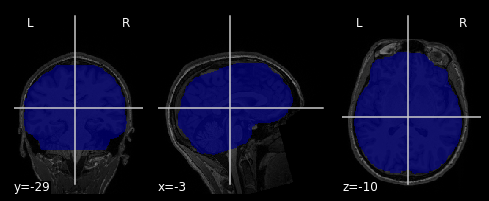

In [5]:
mask_imgs=[]
for run in range(run_order_start[0],run_order_start[0]+n_runs[0]):
    mask_name = bold_dir + sub + '_ses-01_task-localizer_run-%i_space-T1w_desc-brain_mask.nii.gz' % run
    mask_imgs.append(mask_name)
    
avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)

# plot
t1_file = anat_dir + sub + '_ses-01_desc-preproc_T1w_defaced.nii.gz'
t1_img = image.load_img(t1_file)
plot_roi(avg_mask, bg_img=t1_img)

In [6]:
# Save the mask
output_name = mask_fold + '%s_%s_brain.nii.gz' % (sub, ses)
print('Save average mask:', output_name)
print('')

dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)

hdr = avg_mask.header  # get a handle for the .nii file's header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
nib.save(avg_mask, output_name)

Save average mask: /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/masks/sub-005_ses-01_brain.nii.gz

Mask dimensions: (1.5, 1.5, 1.5)

Affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]


## Drop first few TRs

`n_trunc` sets the number of TRs to drop.

In [7]:
epi_trunc=[]
for run in range(run_order_start[0],run_order_start[0]+n_runs[0]):
    epi_file=bold_dir + sub + '_ses-01_task-localizer_run-%i_space-T1w_desc-preproc_bold.nii.gz' % run
    epi_data=nib.load(epi_file)
    epi=epi_data.get_fdata()
    #hdr=epi_data.get_data.hdr()
    
    # TRIM BEGINNING ONLY
    #epi_trunc =np.zeros((epi_data.shape[0], epi_data.shape[1], epi_data.shape[2], epi_data.shape[3]-n_trunc_beginning))
    #epi_trunc[:, :, :, :] = epi[:,:,:,n_trunc_beginning:]
    
    # TRIM BEGINNING AND END
    epi_trunc =np.zeros((epi_data.shape[0], epi_data.shape[1], epi_data.shape[2], epi_data.shape[3]-n_trunc_beginning-n_trunc_end))
    epi_trunc[:, :, :, :] = epi[:,:,:,n_trunc_beginning:-n_trunc_end]
    
    #epi_truncated
    print('run #%d' % (run))
    print('Original:', epi_data.shape, '  ', 'Truncated:', epi_trunc.shape)
    dimsize=epi_data.header.get_zooms()
    print('Dimensions:', dimsize)
    orig_dimsize=dimsize
    
    affine_mat = epi_data.affine  # What is the orientation of the data
    print('Affine:')
    print(affine_mat)
    print('')
    
    # Save the volume
    output_name = (out_dir + '%s_ses-01_task-localizer_run-0%i_space-T1w_desc-preproc_bold_trim%dand%dTRs.nii.gz' % (sub, run, n_trunc_beginning, n_trunc_end))
    bold_nii = nib.Nifti1Image(epi_trunc, affine_mat)
    hdr = bold_nii.header  # get a handle for the .nii file's header
    hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2], dimsize[3]))
    nib.save(bold_nii, output_name)

run #10
Original: (98, 112, 92, 194)    Truncated: (98, 112, 92, 179)
Dimensions: (1.5, 1.5, 1.5, 1.5)
Affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]

run #11
Original: (98, 112, 92, 194)    Truncated: (98, 112, 92, 179)
Dimensions: (1.5, 1.5, 1.5, 1.5)
Affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]

run #12
Original: (98, 112, 92, 195)    Truncated: (98, 112, 92, 180)
Dimensions: (1.5, 1.5, 1.5, 1.5)
Affine:
[[   1.5    0.     0.   -77. ]
 [   0.     1.5    0.  -110.5]
 [   0.     0.     1.5  -86.5]
 [   0.     0.     0.     1. ]]



## Load fMRI data <a id="load_fmri"></a>

#### Get voxels from an ROI

We will extract BOLD data, only for voxels in a mask, by executing the following sequence of steps: 
1. load whole brain fMRI data (for a given subject and a given run)
2. load the desired mask
3. use `NiftiMasker` to sub-select mask voxels from the whole brain data
    - `NiftiMasker` is a function from nilearn. Here's <a href="https://nilearn.github.io/auto_examples/04_manipulating_images/plot_mask_computation.html">an example</a> about how to use it, and here's the official <a href="https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html">documentation</a>. 

## Apply mask to truncated dataset

In [8]:
epi_mask_data_all=[]

# 1. Load the fMRI data 
for run in range(run_order_start[0],run_order_start[0]+n_runs[0]):

    epi_masker= NiftiMasker(
        mask_img=avg_mask,  
        high_pass=1/128,
        standardize=True,  # Are you going to zscore the data across time?
        t_r=adderzip_TR, 
        memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
        memory_level=1,  # How much memory will you cache?
        verbose=0
    )

    epi_file=out_dir + '%s_ses-01_task-localizer_run-0%i_space-T1w_desc-preproc_bold_trim%dand%dTRs.nii.gz' % (sub, run, n_trunc_beginning, n_trunc_end)
    # confound_file= bold_dir + '%s_confounds_selected_r0%i.txt' % (sub, run)
    
    # epi_mask_data = epi_masker.fit_transform(epi_file, confounds=confound_file)
    epi_mask_data = epi_masker.fit_transform(epi_file)

    if run==run_order_start[0]:
        epi_mask_data_all=epi_mask_data
    else:
        epi_mask_data_all=np.vstack([epi_mask_data_all,epi_mask_data])
        
    # Save the volume
    print('Saving trimmed and normalized volume for run', run)
    
    affine_mat = avg_mask.affine #should be the same as the epi data
    avg_mask.shape
    coords = np.where(avg_mask.get_fdata())
    bold_vol=[]
    bold_vol =np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_data.shape[0]))
    bold_vol[coords[0], coords[1], coords[2], :] = epi_mask_data.T
    print('epi_mask_data shape:', bold_vol.shape)
    print('')
    
    output_name = (out_dir + '%s_ses-01_task-localizer_run-0%i_space-T1w_desc-preproc_bold_trim%dand%dTRs_normalized.nii.gz' % (sub, run, n_trunc_beginning, n_trunc_end))
    bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
    hdr = bold_nii.header  # get a handle for the .nii file's header
    hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
    nib.save(bold_nii, output_name)

print('Volumes saved')
# print(epi_mask_data_all.shape)

Saving trimmed and normalized volume for run 10
epi_mask_data shape: (98, 112, 92, 179)

Saving trimmed and normalized volume for run 11
epi_mask_data shape: (98, 112, 92, 179)

Saving trimmed and normalized volume for run 12
epi_mask_data shape: (98, 112, 92, 180)

Volumes saved


In [9]:
avg_mask.shape
coords = np.where(avg_mask.get_fdata())
#print(avg_mask)

dimsize=avg_mask.header.get_zooms()
print('Voxel dimensions:', dimsize)

affine_mat = avg_mask.affine  # What is the orientation of the data

bold_vol=[]
bold_vol =np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_data_all.shape[0]))
bold_vol[coords[0], coords[1], coords[2], :] = epi_mask_data_all.T

print('avg_mask shape:', avg_mask.shape)
print('epi_mask_data shape:', bold_vol.shape)
print('epi_mask_data_all shape(timepoints, voxels):', epi_mask_data_all.shape)

Voxel dimensions: (1.5, 1.5, 1.5)
avg_mask shape: (98, 112, 92)
epi_mask_data shape: (98, 112, 92, 538)
epi_mask_data_all shape(timepoints, voxels): (538, 428358)


In [10]:
# Save the concatenated volume
output_name = out_dir + '%s_ses-01_task-localizer_run-ALL_space-T1w_desc-preproc_bold_trim%dand%dTRs_normalized.nii.gz' % (sub, n_trunc_beginning, n_trunc_end)
print('Save concatenated data:', output_name)
print('')
bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
hdr = bold_nii.header  # get a handle for the .nii file's header
print('Dimensions:', orig_dimsize) #4th dimension is TR
print('')
hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
nib.save(bold_nii, output_name)
print('Volume saved')

Save concatenated data: /jukebox/norman/karina/adderzip_fMRI/adderzip/data/bids/derivatives/firstlevel/sub-005/ses-01/sub-005_ses-01_task-localizer_run-ALL_space-T1w_desc-preproc_bold_trim5and10TRs_normalized.nii.gz

Dimensions: (1.5, 1.5, 1.5, 1.5)

Volume saved


## Plot a volume from each run to check normalization step

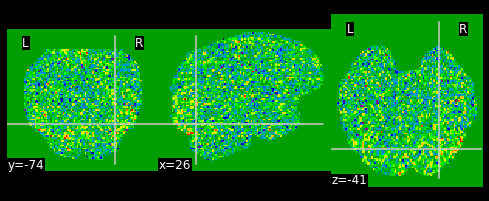

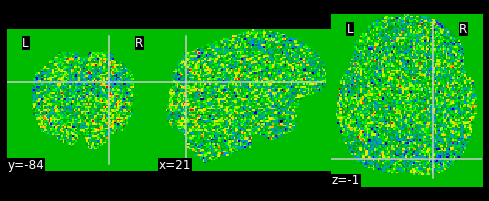

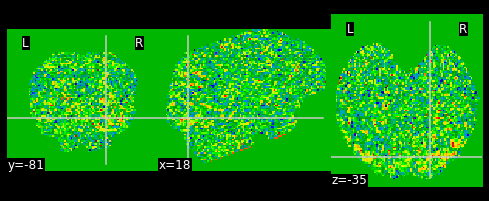

In [11]:
vol_num=0
for run in range(run_order_start[0],run_order_start[0]+n_runs[0]):
     func_name = (out_dir + '%s_ses-01_task-localizer_run-0%i_space-T1w_desc-preproc_bold_trim%dand%dTRs_normalized.nii.gz' % (sub, run, n_trunc_beginning, n_trunc_end))
     image.load_img(func_name)
     first_vol = image.index_img(func_name,vol_num)
     #mean_func = mean_img(func_name)
     plot_epi(first_vol)

### 3.1. Plot a voxel time-series <a id="plot_voxel"></a>

After masking, the fMRI dataset at this stage (found in the variable epi_mask_data that was created in the cell above) is in the format rows=time (i.e. 310 rows referring to 310 TRs) and columns=voxels (i.e. the number of voxels in the mask).

In [ ]:
# Plot value of voxel_id through time point 550 (there are only 538 time points)
voxel_id = 200

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(epi_mask_data_all[:, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')

# plt.figure(figsize=(10,10))
# plt.imshow(epi_mask_data_all[200:300,voxel_id-100:voxel_id+100])
# plt.colorbar()
# plt.show()

## Check mean and standard deviation of normalized data 

In [23]:
x_mean = np.mean(epi_mask_data_all, axis=0)
x_std = np.std(epi_mask_data_all, axis=0, dtype=np.float64)

print('the mean of 1st few time points:\n', x_mean[0:10])
print('')
print('the std of 1st few time points:\n', x_std[0:10])
print('')
print(np.shape(x_mean))
print(np.shape(x_std))
print('')
print(np.amin(x_mean), np.amax(x_mean))
print(np.amin(x_std), np.amax(x_std))

# print(x_std)

the mean of 1st few time points:
 [ 4.39033362e-17  6.71705566e-17 -4.53994545e-18  2.86842008e-17
 -3.49782161e-17  2.88905620e-17 -8.25444628e-18 -1.39809684e-17
  2.06361157e-17  8.28024142e-18]

the std of 1st few time points:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

(428358,)
(428358,)

-1.4612949429603883e-16 1.7127976030462452e-16
0.9999999999999984 1.0000000000000013


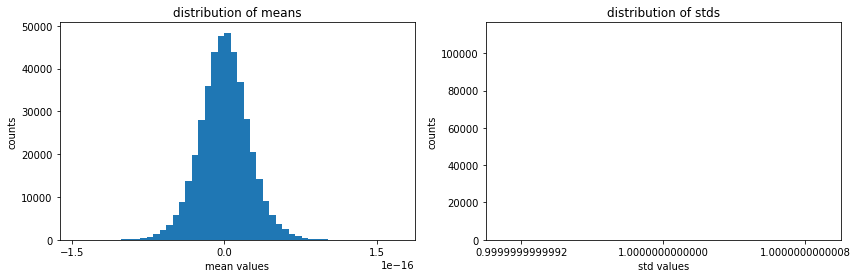

In [24]:
f, axes = plt.subplots(1, 2, figsize = (14,4))

n_bins = 50

axes[0].hist(x_mean, bins = n_bins)
axes[0].set_title('distribution of means')
axes[0].set_xlabel('mean values')
axes[0].set_ylabel('counts')
axes[0].xaxis.set_major_locator(plt.MaxNLocator(3))

axes[1].hist(x_std, bins = n_bins)
axes[1].set_title('distribution of stds')
axes[1].set_xlabel('std values')
axes[1].set_ylabel('counts')
axes[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axes[1].get_xaxis().get_major_formatter().set_useOffset(False)

plt.show()